In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *
import h5py
from sklearn.preprocessing import OneHotEncoder
from cbrain.climate_invariant import *
import yaml
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();
path = '/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

## Data Generators

### Data Generator for RH

In [3]:
scale_dict = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'
BASE_DIR = '/DFS-L/DATA/pritchard/ankitesg/'

In [4]:
train_gen_RH = DataGenerator(
    data_fn = f"{BASE_DIR}data/{TRAINFILE_RH}",
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = f"{BASE_DIR}data/{NORMFILE_RH}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Data Generator for TNS

In [5]:
in_vars = ['QBP','TfromNSV2','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_TNS = 'CI_TNSV2_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNSV2_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNSV2_M4K_NORM_valid.nc'

In [6]:
train_gen_TNS = DataGenerator(
    data_fn = f"{BASE_DIR}data/{TRAINFILE_TNS}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE_TNS}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Data Generator Combined

In [7]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [8]:
## this won't be used just to show we can use it overall
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

In [9]:
train_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{TRAINFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)

valid_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{VALIDFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)


## Build Model

In [41]:
inp = Input(shape=(64,))
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(64, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128)               0   

In [56]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'RH_TNSV2_LH.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [57]:
Nep = 10
model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/20
  997/41376 [..............................] - ETA: 19:57 - loss: 933.7019

KeyboardInterrupt: 

### Model with TNS and LHFLX transformation

In [9]:
train_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{TRAINFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)

valid_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{VALIDFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)


ban toh raha hai
None
ban toh raha hai
None


In [10]:
train_gen[0][0]

array([[-3.1150199e-02, -2.5735410e-02, -5.7867717e-02, ...,
        -9.6184701e-02, -8.5013285e-03, -2.6119235e-06],
       [-3.0725701e-02, -2.4526425e-02, -4.3158535e-02, ...,
        -1.1248506e-01,  1.8772926e-02, -5.9310842e-06],
       [-3.0707045e-02, -2.4309644e-02, -4.8080746e-02, ...,
        -2.0640454e-01, -2.7730091e-02, -7.2621669e-06],
       ...,
       [-3.1045359e-02, -2.4920296e-02, -4.6747047e-02, ...,
        -2.3120576e-01, -1.3915333e-02,  1.0293472e-06],
       [-3.1090843e-02, -2.5133165e-02, -5.3446773e-02, ...,
        -2.3120576e-01, -4.2218819e-02, -1.1578744e-06],
       [-3.0709369e-02, -2.4279768e-02, -4.7063876e-02, ...,
        -2.3120576e-01, -6.9839531e-03, -9.0505199e-07]], dtype=float32)

In [11]:
inp = Input(shape=(64,))
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(64, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [12]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'RH_TNSV2_LHV2.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [13]:
with tf.device('/gpu:2'):
    Nep = 10
    model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
                  callbacks=[earlyStopping, mcp_save])

Epoch 1/10
41376/41376 [==============================] - 1451s 35ms/step - loss: 440.0452 - val_loss: 399.6728
Epoch 2/10
41376/41376 [==============================] - 1451s 35ms/step - loss: 399.2769 - val_loss: 392.4239
Epoch 3/10
41376/41376 [==============================] - 1465s 35ms/step - loss: 393.5937 - val_loss: 388.5102
Epoch 4/10
41376/41376 [==============================] - 1462s 35ms/step - loss: 390.2530 - val_loss: 384.5634
Epoch 5/10
41376/41376 [==============================] - 1468s 35ms/step - loss: 388.2070 - val_loss: 385.2683
Epoch 6/10
41376/41376 [==============================] - 1476s 36ms/step - loss: 386.8442 - val_loss: 384.8619
Epoch 7/10
41376/41376 [==============================] - 1483s 36ms/step - loss: 385.7476 - val_loss: 382.8121
Epoch 8/10
41376/41376 [==============================] - 1477s 36ms/step - loss: 384.6677 - val_loss: 380.8941
Epoch 9/10
41376/41376 [==============================] - 2661s 64ms/step - loss: 383.8629 - val_loss: 3

## Model Diagonostics

In [42]:
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']  # Validation/test data sets
NNarray = ['RH.hdf5', 'RH_TNSV2_LHV2_Interp_2.hdf5'] # NN to evaluate 
NNname = ['RH','RH-TNSV2-LHV2-Interp'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [43]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)


In [44]:

#define default values


NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    
    rh_trans=False
    t2tns_trans=False
    lhflx_trans=False
    scaling=False
    interpolate=False
    model = path
    exp=None
    pos_model=None
    neg_model=None
    if 'RH' in NNs:
        rh_trans=True
    if 'TNS' in NNs:
        t2tns_trans=True
    if 'LH' in NNs:
        lhflx_trans=True
    if 'V2' in NNs:
        if "LHV2":
            exp = {"LHFLX":True}
        else:
            exp = {"LHFLX":False}
        
    if 'Scal' in NNs:
        pos,neg = NNs.split('*')
        pos_model = path_HDF5+pos
        neg_model = path_HDF5+neg
        model = None
        scaling=True
    if 'Interp' in NNs or 'Vert' in NNs:
        interpolate=True
        
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                     '/DFS-L/DATA/pritchard/ankitesg/data/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                     inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                     rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                     lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                     model=model,exp=exp)
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                                '/DFS-L/DATA/pritchard/ankitesg/data/'+data)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  RH.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:998: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:998: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:998: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNSV2_LHV2_Interp_2.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:998: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [45]:
lat_ind = np.arange(26,40)
iinis = [1500]

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
diagno['truth_pos'] = {} # Diagnostics structure for the truth pos
diagno['truth_neg'] = {} # Diagnostics structure for the truth neg
diagno['MSE'] = {}
truth_done = {}

for j,data in enumerate(data_file):
    truth_done[data[6:-3]] = False

for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    diagno[NNs]['MSE'] = {}
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        diagno[NNs]['MSE'][data[6:-3]]={}
        if i==0: 
            diagno['truth'][data[6:-3]]={}
            diagno['truth_pos'][data[6:-3]]={}
            diagno['truth_neg'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+1
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: 
                diagno['truth'][data[6:-3]][iini] = {}
                diagno['truth_pos'][data[6:-3]][iini] = {}
                diagno['truth_neg'][data[6:-3]][iini] = {}
                
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                truth_geo =  md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]

                ## only if the scaling is true
                if NN[NNs].scaling==True:
                    X, _ = md[NNs][data[6:-3]].valid_gen[itime]
                    mask, pos_op, neg_op = md[NNs][data[6:-3]].model.predict_on_batch_seperate(X.values)
                    mask_reshaped = md[NNs][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                    mask = mask_reshaped.flatten()
                    neg_mask = np.logical_not(mask)
                    ## get the truth only once.
                p = np.array(p)
                p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    ##if scaling is true and the truth array is not filled
                    if NN[NNs].scaling==True and truth_done[data[6:-3]]==False:
                        diagno['truth_pos'][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_pos'][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_neg'][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno['truth_neg'][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        truth_done[data[6:-3]] = True
                                                    
                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    
#                     print(NNs)
#                     print("----------------------")
                    diagno[NNs]['MSE'][data[6:-3]] = np.mean((truth_geo-p_geo)**2,axis=(1,2))
#                     print(truth_geo)
#                     print(p_geo)
#                     print(diagno[NNs]['MSE'][data[6:-3]])
#                     print("----------------------")
                    if NN[NNs].scaling==True:
                        diagno[NNs][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]

                else:
                    diagno[NNs]['MSE'][data[6:-3]] = np.concatenate((diagno[NNs]['MSE'][data[6:-3]],
                           np.mean((truth_geo-p_geo)**2,axis=(1,2))),axis=0)
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if NN[NNs].scaling==True:
                            diagno[NNs][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                        axis=0)

                            diagno[NNs][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)
                        if i==0:

                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
                            
                            if NN[NNs].scaling==True:
                                diagno['truth_pos'][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno['truth_pos'][data[6:-3]][iini][field+'_pos'],
                                             md[NNs][data[6:-3]].\
                                             reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                            axis=0)
                                diagno['truth_neg'][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno['truth_neg'][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)



i= 0 & NNs= RH.hdf5          


/export/home/ankitesg/anaconda3/envs/CBrainEnv/lib/python3.6/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= RH_TNSV2_LHV2_Interp_2.hdf5          


In [46]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

['RH', 'RH-TNSV2-LHV2-Interp']


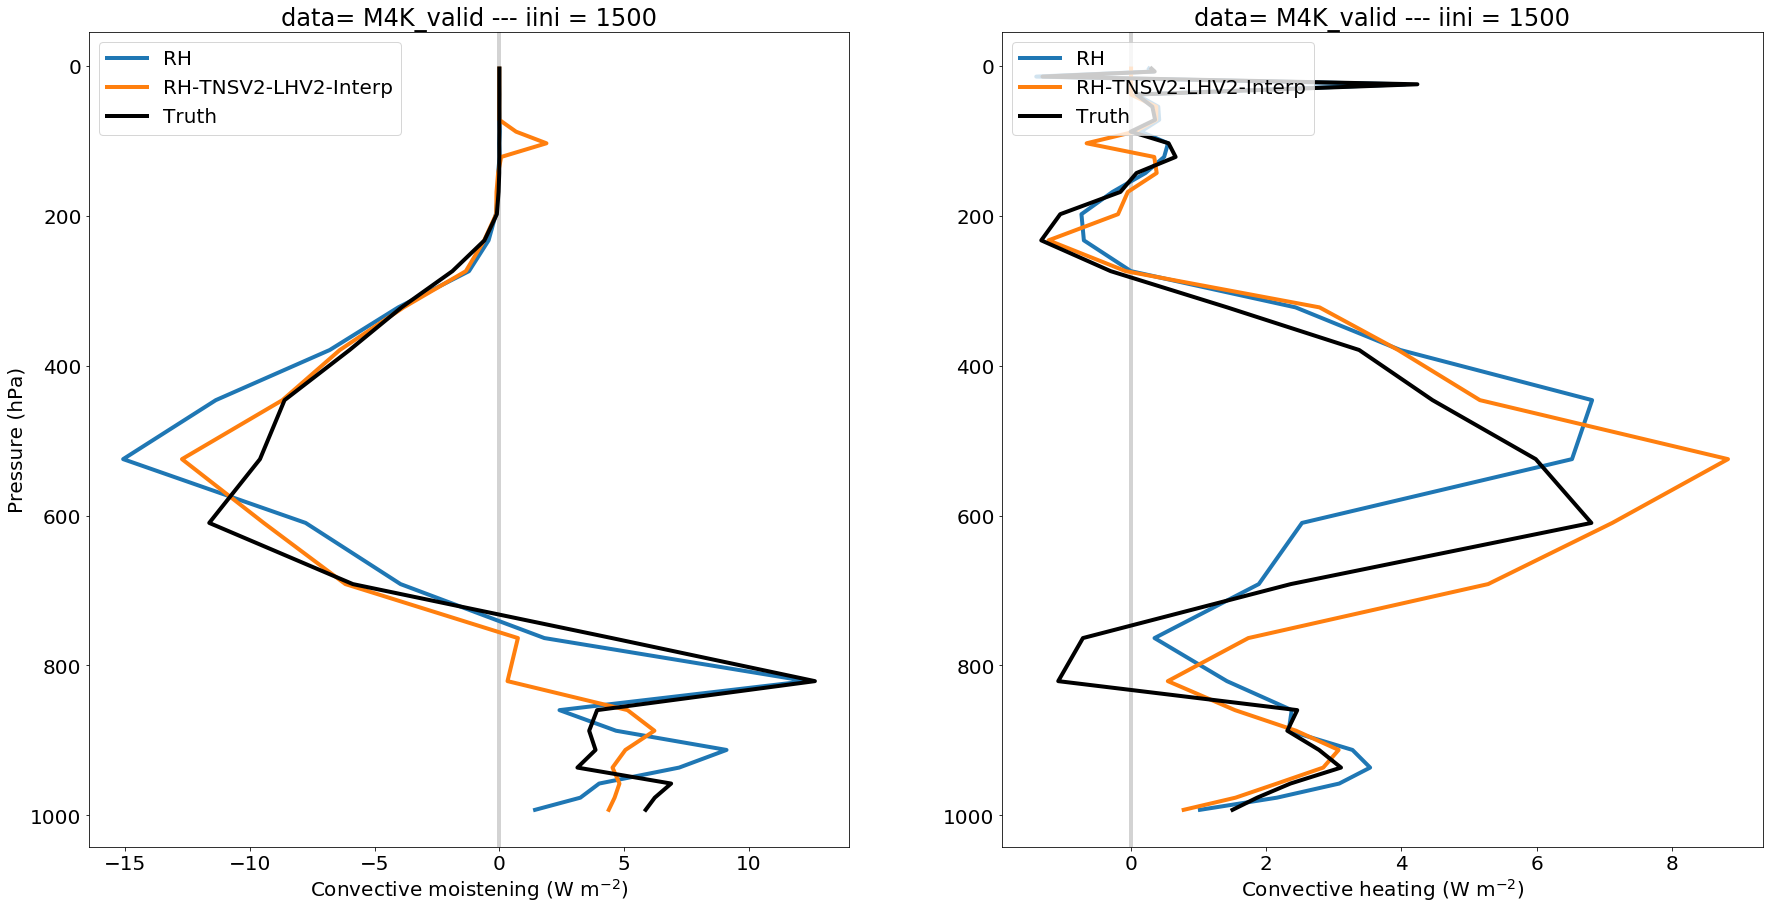

In [47]:


data = data_file[0][6:-3]
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
print(NNname)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


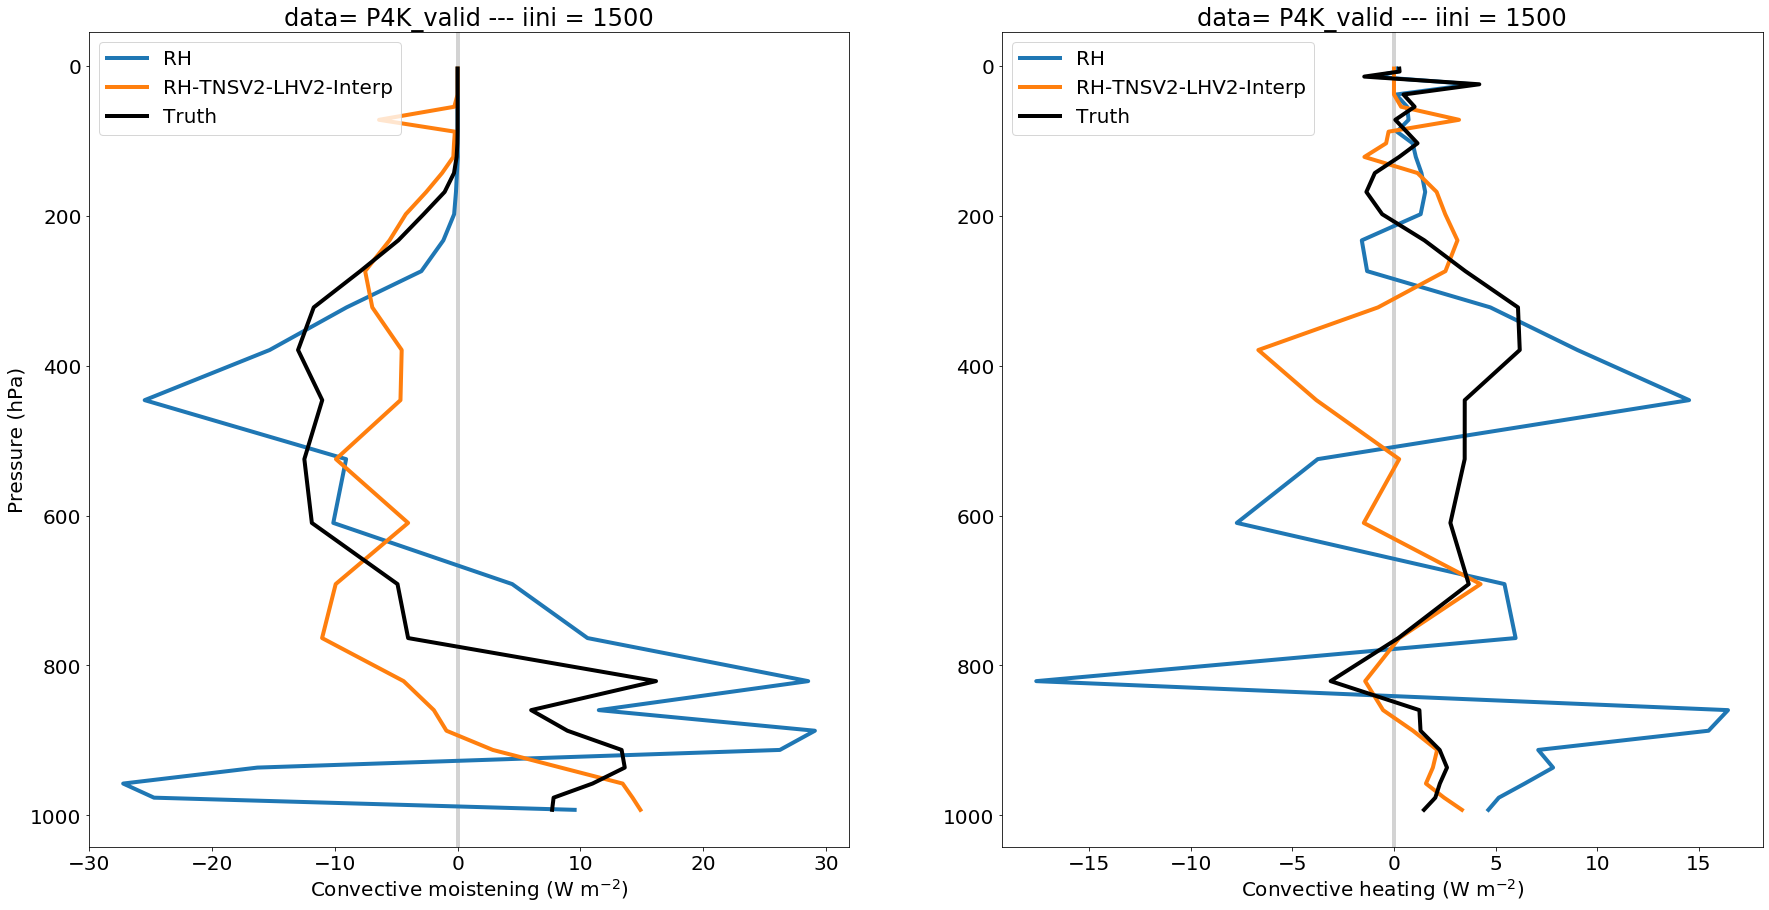

In [48]:


data = data_file[1][6:-3]
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


## MSE

In [18]:
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']  # Validation/test data sets
NNarray = ['BF.hdf5','CI01_RH_TNS_LHQsat.hdf5', 'RH_TNSV2_LHV2_correct.hdf5','RH.hdf5', 'RH_TNS.hdf5'] # NN to evaluate 
NNname = ['BF','RH-TNS-LH','RH-TNSV2-LHV2','RH', 'RH-TNS'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [19]:

#define default values


NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    
    rh_trans=False
    t2tns_trans=False
    lhflx_trans=False
    scaling=False
    interpolate=False
    model = path
    exp=None
    pos_model=None
    neg_model=None
    if 'RH' in NNs:
        rh_trans=True
    if 'TNS' in NNs:
        t2tns_trans=True
    if 'LH' in NNs:
        lhflx_trans=True
    if 'V2' in NNs:
        if "LHV2":
            exp = {"LHFLX":True}
        else:
            exp = {"LHFLX":False}
        
    if 'Scal' in NNs:
        pos,neg = NNs.split('*')
        pos_model = path_HDF5+pos
        neg_model = path_HDF5+neg
        model = None
        scaling=True
    if 'Interp' in NNs or 'Vert' in NNs:
        interpolate=True
        
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                     '/DFS-L/DATA/pritchard/ankitesg/data/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                     inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                     rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                     lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                     model=model,exp=exp)
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                                '/DFS-L/DATA/pritchard/ankitesg/data/'+data)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  BF.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  CI01_RH_TNS_LHQsat.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNSV2_LHV2_correct.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:990: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [20]:
Nt = 30
data = data_file[0]
t_random = np.random.choice(np.linspace(0,md[NNs][data[6:-3]].valid_gen.n_batches-1,
                                        md[NNs][data[6:-3]].valid_gen.n_batches),
                            size=((Nt,)),replace=False).astype('int')

MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime)
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}
        for j,data in enumerate(data_file):
            #print('j=',j,'data=',data)

            inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]

            t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
            if tf.is_tensor(p): p_geo = md[NNs][data[6:-3]].reshape_ngeo(p.numpy())[:,:,:]
            else: p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]

            if iar==0: 
                MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=(1,2))
                VAR[NNs][data[6:-3]] = np.var(p_geo,axis=(1,2))
            else: 
                MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                       np.mean((t_geo-p_geo)**2,axis=(1,2))),axis=0)
                VAR[NNs][data[6:-3]] = np.concatenate((VAR[NNs][data[6:-3]],
                                                       np.var(p_geo,axis=(1,2))),axis=0)

iar= 0 / 29  & itime 461
iar= 1 / 29  & itime 1271
iar= 2 / 29  & itime 1119
iar= 3 / 29  & itime 901
iar= 4 / 29  & itime 1628
iar= 5 / 29  & itime 605
iar= 6 / 29  & itime 435
iar= 7 / 29  & itime 1058
iar= 8 / 29  & itime 1486
iar= 9 / 29  & itime 153
iar= 10 / 29  & itime 99
iar= 11 / 29  & itime 1676
iar= 12 / 29  & itime 249
iar= 13 / 29  & itime 808
iar= 14 / 29  & itime 1379
iar= 15 / 29  & itime 337
iar= 16 / 29  & itime 1470
iar= 17 / 29  & itime 1115
iar= 18 / 29  & itime 1444
iar= 19 / 29  & itime 843
iar= 20 / 29  & itime 688
iar= 21 / 29  & itime 1685
iar= 22 / 29  & itime 223
iar= 23 / 29  & itime 342
iar= 24 / 29  & itime 800
iar= 25 / 29  & itime 158
iar= 26 / 29  & itime 344
iar= 27 / 29  & itime 278
iar= 28 / 29  & itime 478
iar= 29 / 29  & itime 339


In [21]:
for i, name in enumerate(NNname):
    print(f"{name} MSE={np.sqrt(MSE[NNarray[i]]['M4K_valid'].mean())} STD={np.sqrt(MSE[NNarray[i]]['M4K_valid'].std())}")

BF MSE=18.71283531188965 STD=21.24545669555664
RH-TNS-LH MSE=26406.447265625 STD=16190.765625
RH-TNSV2-LHV2 MSE=18.64312744140625 STD=21.205299377441406
RH MSE=18.565412521362305 STD=21.225208282470703
RH-TNS MSE=19094.1640625 STD=10975.4296875


In [22]:
for i, name in enumerate(NNname):
    print(f"{name} MSE={np.sqrt(MSE[NNarray[i]]['P4K_valid'].mean())} STD={np.sqrt(MSE[NNarray[i]]['P4K_valid'].std())}")

BF MSE=121.06480407714844 STD=193.5349884033203
RH-TNS-LH MSE=27050.302734375 STD=14895.455078125
RH-TNSV2-LHV2 MSE=34.556800842285156 STD=41.53977584838867
RH MSE=29.874292373657227 STD=35.615516662597656
RH-TNS MSE=19281.1328125 STD=9710.6123046875


## idea classification 2

In [16]:
perc_path = '/export/nfs0home/ankitesg/data/percentile_data_bin_size_1000.pkl'
perc_array_m4k = load_pickle(perc_path)['Percentile']['M4K']
perc_array_p4k = load_pickle(perc_path)['Percentile']['P4K']
PERC_BINS = np.linspace(0,100,1001)

In [17]:
## Model RH.hdf5
md_name = 'RH.hdf5'
model = md[md_name]

In [18]:
model

{'M4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x7f93506d9d68>,
 'P4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x7f9304752c50>}

In [19]:
def convert_from_physical_to_percentile(p, PERC):
    ans = []
    var_dict = {"PHQ":PHQ_idx, "TPHYSTND":TPHYSTND_idx}
    for var in var_dict.keys():
        p_var = p[:,var_dict[var]]
        perc_var = PERC[var]
        lev_preds = []
        for ilev in range(30):
            lev_preds.append(np.interp(p_var[:,ilev],perc_var[ilev],PERC_BINS))
        p_percentile = np.stack(lev_preds, axis=1)
        ans.append(p_percentile)
    return np.concatenate(ans,axis=1)



In [38]:
def convert_from_physical_to_percentile2(p, PERC):
    var = 'PHQ'
    ilev = 29
    perc_var = PERC[var]
    lev_preds = []
    percentile = np.interp(p,perc_var[ilev],PERC_BINS)
    return percentile

In [39]:
convert_from_physical_to_percentile2(5,perc_array_m4k)

63.92915553347702

In [20]:
def convert_from_percentile_to_physical(perc_val, PERC):
    ans = []
    var_dict = {"PHQ":PHQ_idx, "TPHYSTND":TPHYSTND_idx}
    for var in var_dict.keys():
        perc_var = perc_val[:,var_dict[var]]
        perc = PERC[var]
        lev_preds = []
        for ilev in range(30):
            lev_preds.append(np.interp(perc_var[:,ilev],PERC_BINS,perc[ilev]))
        p = np.stack(lev_preds, axis=1)
        ans.append(p)
        
    return np.concatenate(ans,axis=1)


In [40]:
def convert_from_percentile_to_physical_2(perc_val, PERC):

    var = "PHQ"
    ilev = 29
    val = np.interp(perc_val,PERC_BINS,PERC[var][ilev])
    return val



In [41]:
convert_from_percentile_to_physical_2(63.92915553347702, perc_array_p4k)

7.953229779365696

In [43]:
lat_ind = np.arange(26,40)
iinis = 200
iend = iinis+1

vals = {}
truth_vals = {}
for itime in tqdm(np.arange(iini,iend)):
    inp, p, truth = model['P4K_valid'].get_inp_pred_truth(itime)  
    p = p.numpy()
    percentil_space = convert_from_physical_to_percentile(p, perc_array_m4k)
    val = convert_from_percentile_to_physical(percentil_space,perc_array_p4k)
    if itime==iini:
        truth_vals['PHQ'] = model['P4K_valid'].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
        truth_vals['TPHYSTND'] = model['P4K_valid'].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        vals['PHQ'] = model['P4K_valid'].reshape_ngeo(val[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
        vals['TPHYSTND'] = model['P4K_valid'].reshape_ngeo(val[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

    else:
        
        vals['PHQ']  = np.concatenate((vals['PHQ'],
                                      model['P4K_valid'].\
                                     reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]),
                                    axis=3)
        vals['TPHYSTND']  = np.concatenate((vals['TPHYSTND'],
                                      model['P4K_valid'].\
                                     reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]),
                                    axis=3)
        
        truth_vals['PHQ'] = np.concatenate((truth_vals['PHQ'],
                                                     model['P4K_valid'].\
                                                     reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
        
        truth_vals['TPHYSTND'] = np.concatenate((truth_vals['TPHYSTND'],
                                             model['P4K_valid'].\
                                             reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]),
                                            axis=3)

/export/home/ankitesg/anaconda3/envs/CBrainEnv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [24]:
vals['PHQ'].shape

(14, 128, 30, 47)

In [25]:
path = '/export/nfs0home/ankitesg/data/percentile_data_bin_size_1000.pkl'

In [26]:
dumped = load_pickle(path)
perc = dumped['Percentile']

(0, 20)

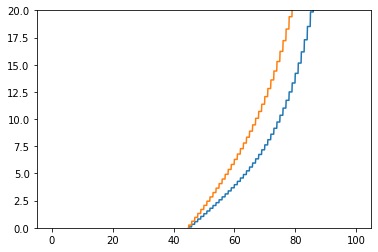

In [33]:
plt.plot(np.arange(0,1001)/10, perc['M4K']['PHQ'][29])
plt.plot(np.arange(0,1001)/10, perc['P4K']['PHQ'][29])
plt.ylim((0,20))

(-20, 20)

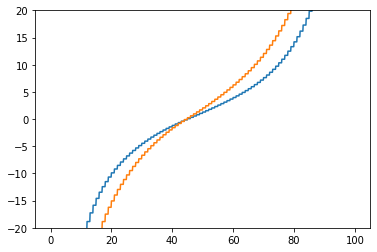

In [42]:
plt.plot(np.arange(0,1001)/10, perc['M4K']['PHQ'][29])
plt.plot(np.arange(0,1001)/10, perc['P4K']['PHQ'][29])
plt.ylim((-20,20))

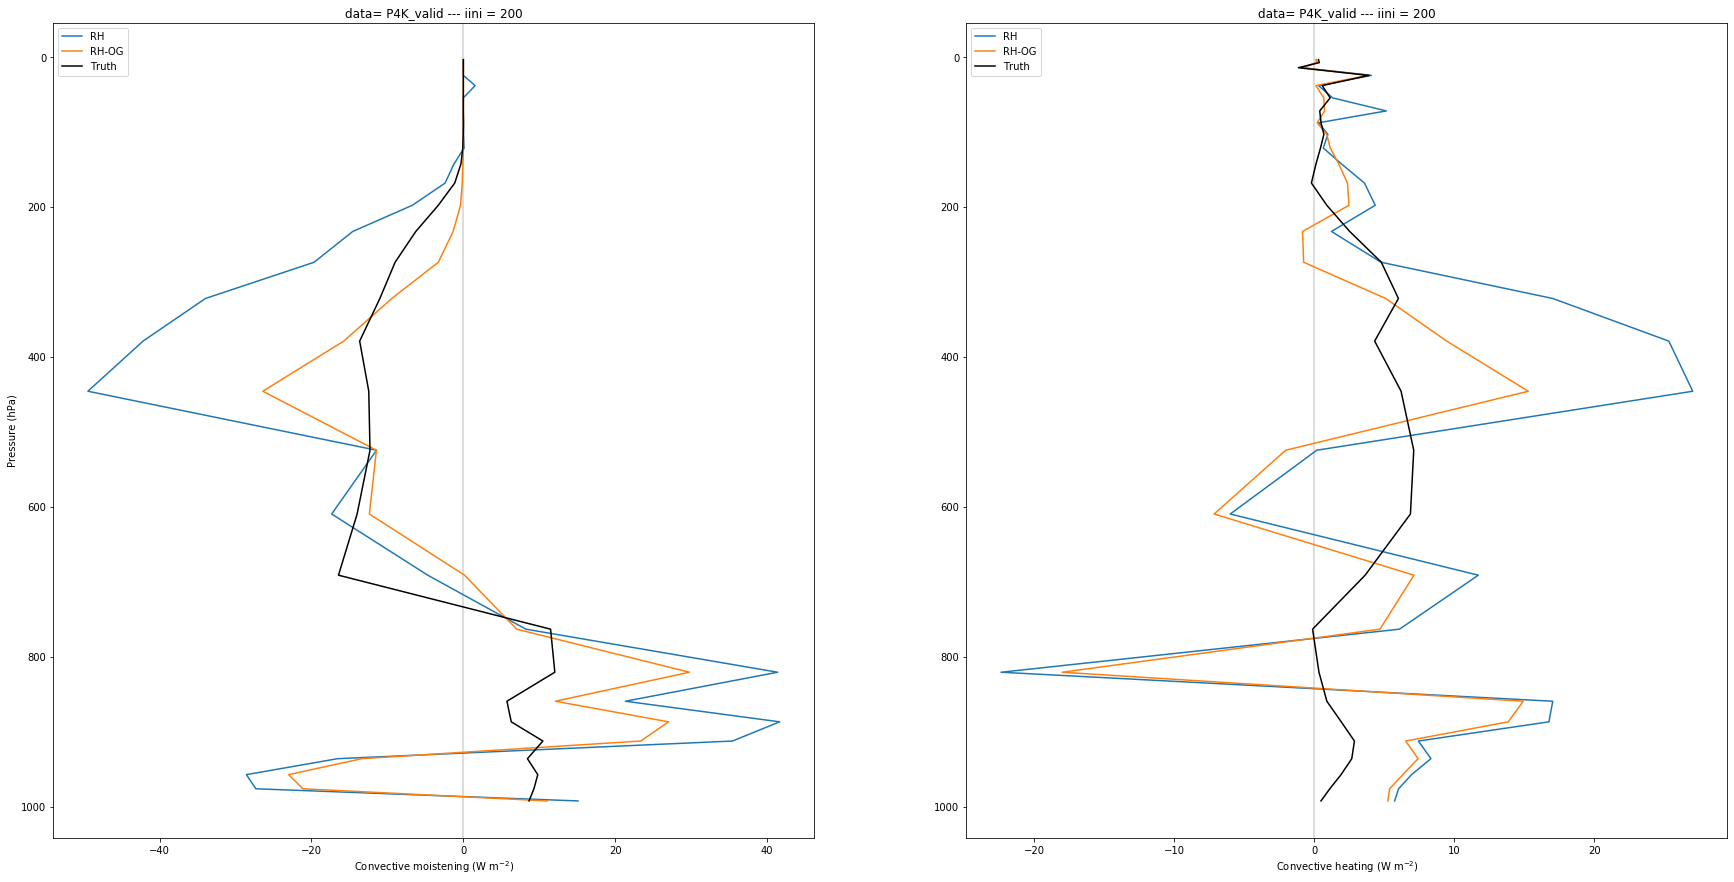

In [44]:
data = data_file[1][6:-3]
name = 'RH'
plt.figure(figsize=(30,15))
iini = 200
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
plt.plot(np.mean(vals['PHQ'],axis=(0,1,3)),lev,label=name)
plt.plot()
plt.plot(np.mean(diagno['RH.hdf5'][data][iini]['PHQ'],axis=(0,1,3)),lev,label=f'{name}-OG')
plt.plot(np.mean(truth_vals['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
plt.plot(np.mean(vals['TPHYSTND'],axis=(0,1,3)),lev,label=name)
plt.plot(np.mean(diagno['RH.hdf5'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=f'{name}-OG')
plt.plot(np.mean(truth_vals['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


## Post Processing Idea

In [16]:
# data from the warm 
TRAINFILE_P4k = 'CI_SP_P4K_train_shuffle.nc'
NORMFILE_P4k = 'CI_SP_P4K_NORM_norm.nc'
VALIDFILE_P4k = 'CI_SP_P4K_valid.nc'

train_gen_p4k = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{TRAINFILE_P4k}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE_P4k}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)

In [157]:
def levTildeV2(X,lev_tilde,inp_sub,inp_div,batch_size=1024, interm_dim_size=40):
    '''can be used independently
        note: the input X should be raw transformed i.e without any other transformation(RH or QV)
        or if given in that way then please provide appropriate inp_sub, inp_div
    ''' ## not being used in the process method
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denormalized = X_denormalized[:,30:60]
    lev_tilde_after_single = np.linspace(-0.4,1,num=interm_dim_size)
    #-0.4 to 1
    X_temperature_after = []
    X_pressure_after = []
    ##. x , xp , fp x=ne_coordinatoe, xp=t-tilde, fp=t-tilde
    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, lev_tilde[i], X_temperature[i][5:]))
        X_pressure_after.append(np.interp(lev_tilde_after_single, lev_tilde[i], X_pressure[i][5:]))

    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)

    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))

    return  X_result

In [46]:
train_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{TRAINFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)

In [47]:
inp_subTNS=train_gen_TNS.input_transform.sub
inp_divTNS=train_gen_TNS.input_transform.div
t2tns_trans = T2TmTNSNumpy(train_gen.inp_sub,train_gen.inp_div,inp_subTNS,inp_divTNS,
                           hyam,hybm)

In [162]:
X = train_gen[4][0]
X.shape

(1024, 64)

In [49]:
t2tns_trans.process(X)

array([[ 7.4327596e-05,  4.6931440e-05,  6.7933629e-06, ...,
        -9.6184701e-02, -8.5013285e-03, -2.7405389e-02],
       [-7.0042050e-05, -5.9645296e-05, -2.3435006e-05, ...,
        -1.1248506e-01,  1.8772926e-02, -6.5641336e-02],
       [-7.4295713e-05, -6.0925850e-05, -3.1120508e-05, ...,
        -2.0640454e-01, -2.7730091e-02, -7.4780263e-02],
       ...,
       [-5.9461756e-05, -8.6630367e-05, -7.6661228e-05, ...,
        -2.3120576e-01, -1.3915333e-02,  3.1539451e-02],
       [-6.4512336e-05, -4.4839813e-05, -6.1506937e-05, ...,
        -2.3120576e-01, -4.2218819e-02, -3.1189363e-02],
       [-9.4612675e-05, -8.2056213e-05, -4.2958276e-05, ...,
        -2.3120576e-01, -6.9839531e-03, -1.4765143e-02]], dtype=float32)

In [168]:
lev_tilde = tranform_lev_tilde(X)
new_cord = levTildeV2(X,lev_tilde,train_gen.inp_sub, train_gen.inp_div)

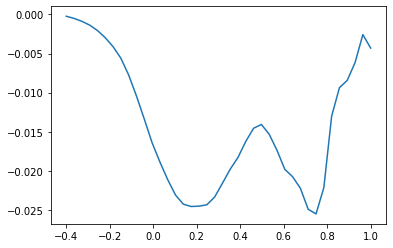

In [169]:
plt.plot(np.linspace(-0.4,1,num=40), np.mean(new_cord[:,:40],axis=0))

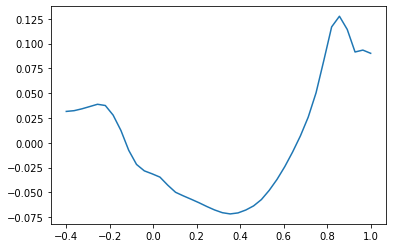

In [170]:
plt.plot(np.linspace(-0.4,1,num=40), np.mean(new_cord[:,40:80],axis=0))

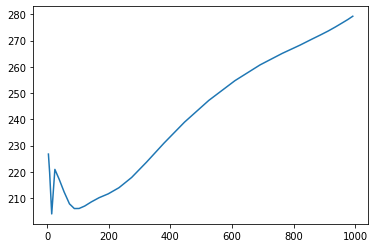

In [165]:
plt.plot(lev, np.mean(X[:,30:60]*train_gen.inp_div[30:60]+train_gen.inp_sub[30:60],axis=0))

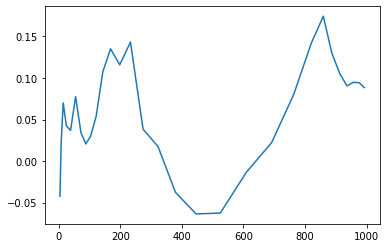

In [166]:
plt.plot(lev, np.mean(X[:,30:60],axis=0))

In [120]:
def tranform_lev_tilde(X):
    lev_tilde = t2tns_trans.process(X)[0][30:60]*inp_divTNS[30:60] + inp_subTNS[30:60]
    lev_tilde_temp = lev_tilde[5:]
    diff = np.diff(lev_tilde_temp)
    concatenated = []
    for i in range(X.shape[0]):
        conc = np.concatenate((lev_tilde_temp[:-1][diff<0] + 2*np.flip(np.cumsum(np.flip(diff[diff<0]))),lev_tilde_temp[:-1][diff>0], [1.]))
        concatenated.append(conc)
    return np.stack(concatenated)

In [121]:
tranform_lev_tilde(X)

array([-0.6874789 , -0.61896408, -0.59885216, -0.57324684, -0.5413419 ,
       -0.50951761, -0.44242188, -0.34798414, -0.3062245 , -0.19502214,
       -0.03196639,  0.12888359,  0.29966295,  0.46840173,  0.59491241,
        0.69762111,  0.77397627,  0.82452834,  0.84931678,  0.8618536 ,
        0.8857553 ,  0.9150579 ,  0.94549012,  0.97360051,  1.        ])

In [167]:
def tranform_lev_tilde(X):
    lev_tilde = t2tns_trans.process(X)[:,30:60]*inp_divTNS[30:60] + inp_subTNS[30:60]
    concatenated = []
    for i in range(X.shape[0]):
        lev_tilde_temp = lev_tilde[i,5:]
        diff = np.diff(lev_tilde_temp)
        conc = np.concatenate((lev_tilde_temp[:-1][diff<0] + 2*np.flip(np.cumsum(np.flip(diff[diff<0]))),lev_tilde_temp[:-1][diff>0], [1.]))
        concatenated.append(conc)
    return np.stack(concatenated)

In [156]:
tranform_lev_tilde(X)

(1024, 25)

In [171]:
def convert_to_monotonically_increasing(lev_tilde):
    concatenated = []
    for i in range(lev_tilde.shape[0]):
        lev_tilde_temp = lev_tilde[i,5:]
        diff = np.diff(lev_tilde_temp)
        conc = np.concatenate((lev_tilde_temp[:-1][diff<0] + 2*np.flip(np.cumsum(np.flip(diff[diff<0]))),lev_tilde_temp[:-1][diff>0], [1.]))
        concatenated.append(conc)
    return np.stack(concatenated)

In [10]:
train_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{TRAINFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=False,
    lhflx_trans=True,
    scaling=False,
    interpolate=True,
    exp={"LHFLX":True}
)

valid_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{VALIDFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=2,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=False,
    lhflx_trans=True,
    scaling=False,
    interpolate=True,
        exp={"LHFLX":True}
)


In [11]:
def reverseInterp(X, lev_tilde):
    t_list = []
    p_list = []
    for i in range(X.shape[0]):
        p_list.append(np.interp(lev_tilde[i],np.linspace(-0.4,1,40),X[i,:40]))
        t_list.append(np.interp(lev_tilde[i],np.linspace(-0.4,1,40),X[i,40:80]))
    return np.stack(p_list), np.stack(t_list)

In [12]:
train_gen[0][0].shape

(2, 173)

In [13]:
X = train_gen[0][0][:,64:64+84]
lev_tilde = train_gen[0][0][:,64+84:]

In [14]:
p, t = reverseInterp(X,lev_tilde)

In [15]:
p.shape

(2, 25)

In [16]:
p[0]

array([-0.03073957, -0.03073957, -0.03073957, -0.03073957, -0.03073957,
       -0.03073957, -0.03073957,  0.0870248 ,  0.2089256 ,  0.23979307,
        0.23526305,  0.11048173, -0.15851924, -0.32568965, -0.39617217,
       -0.44025716, -0.49359863, -0.52435162, -0.30272596, -0.19628119,
       -0.00736215,  0.04205313,  0.01221806, -0.02712505, -0.05129158])

In [17]:
train_gen.data_ds['vars'][0:2]

array([[ 1.61320258e-06,  1.49719710e-06,  1.20717129e-06,
         1.20547509e-06,  1.12515090e-06,  1.10975031e-06,
         1.07704147e-06,  1.06172797e-06,  1.06179039e-06,
         1.07756910e-06,  1.31706042e-06,  3.20272716e-06,
         5.92261131e-06,  6.39838117e-06,  1.34451593e-05,
         3.81252539e-05,  7.83791256e-05,  8.98698490e-05,
         8.40177090e-05,  7.81637282e-05,  1.19095268e-04,
         2.62923044e-04,  3.81141290e-04,  1.01703766e-03,
         2.00181967e-03,  2.61711865e-03,  2.93141883e-03,
         3.01006413e-03,  3.01636336e-03,  3.19528813e-03,
         2.44887360e+02,  2.34017502e+02,  2.18028503e+02,
         2.38081680e+02,  2.30218430e+02,  2.24061920e+02,
         2.20352707e+02,  2.19263901e+02,  2.17877701e+02,
         2.16150452e+02,  2.14427567e+02,  2.10795181e+02,
         2.05682571e+02,  2.03421814e+02,  2.09442017e+02,
         2.18269424e+02,  2.26977417e+02,  2.36222961e+02,
         2.45358032e+02,  2.52206985e+02,  2.57767365e+0

In [18]:
X_norm = train_gen.input_transform.transform(train_gen.data_ds['vars'][0:2][:,:64])

In [19]:
X_norm

array([[ 7.43275959e-05,  4.69314400e-05,  6.79336290e-06,
         6.59355283e-06,  6.15916997e-06,  3.66710010e-05,
         4.45936275e-05,  5.09618694e-05,  4.65775483e-05,
         4.95339282e-06, -7.60580588e-05,  3.39106409e-05,
        -4.59266215e-04, -3.41602648e-03, -7.60261994e-03,
        -1.27088604e-02, -2.51764785e-02, -6.14383928e-02,
        -9.06054378e-02, -1.27029136e-01, -1.61536083e-01,
        -1.99956134e-01, -2.45831415e-01, -2.27935925e-01,
        -1.84642047e-01, -1.64405227e-01, -1.60499632e-01,
        -1.66353345e-01, -1.65453687e-01, -1.65441796e-01,
         2.01969340e-01,  2.64247686e-01,  3.35449427e-01,
         3.69699359e-01,  3.39694977e-01,  3.53774488e-01,
         2.70486385e-01,  2.33911410e-01,  2.49579340e-01,
         2.56529123e-01,  2.66463578e-01,  1.52275592e-01,
        -5.79341948e-02, -1.57315060e-01, -1.95794523e-01,
        -1.15245424e-01, -1.26517504e-01, -1.23167172e-01,
        -1.06288768e-01, -7.48118758e-02, -5.16881384e-0

In [20]:
after_lh = train_gen.lhflxLayer.process(X_norm)
after_rh = train_gen.qv2rhLayer.process(X_norm)

In [21]:
after_rh[0]

array([-3.11501995e-02, -2.57354099e-02, -5.78677170e-02, -2.70549692e-02,
       -3.61618251e-02, -5.99615760e-02, -7.88417682e-02, -9.66145471e-02,
       -1.26027048e-01, -9.43656489e-02, -1.22566566e-01, -1.08477339e-01,
        6.45790994e-02,  2.46645495e-01,  2.39242613e-01,  2.40533665e-01,
        1.16637245e-01, -1.64604515e-01, -3.28028232e-01, -3.97257060e-01,
       -4.38214809e-01, -4.86457527e-01, -5.66620708e-01, -4.16282088e-01,
       -1.03498280e-01,  3.95796560e-02,  6.12614863e-02,  1.36226751e-02,
       -3.47872153e-02, -5.12915812e-02,  2.01969340e-01,  2.64247686e-01,
        3.35449427e-01,  3.69699359e-01,  3.39694977e-01,  3.53774488e-01,
        2.70486385e-01,  2.33911410e-01,  2.49579340e-01,  2.56529123e-01,
        2.66463578e-01,  1.52275592e-01, -5.79341948e-02, -1.57315060e-01,
       -1.95794523e-01, -1.15245424e-01, -1.26517504e-01, -1.23167172e-01,
       -1.06288768e-01, -7.48118758e-02, -5.16881384e-02, -4.45880555e-03,
        4.18580137e-02,  

In [22]:
after_rh[0][30:60][5:] #interpolated

array([ 0.3537745 ,  0.27048638,  0.23391141,  0.24957934,  0.25652912,
        0.26646358,  0.15227559, -0.05793419, -0.15731506, -0.19579452,
       -0.11524542, -0.1265175 , -0.12316717, -0.10628877, -0.07481188,
       -0.05168814, -0.00445881,  0.04185801,  0.04455107, -0.02875855,
       -0.06004117, -0.07563408, -0.07676005, -0.07162304, -0.06752346],
      dtype=float32)

In [23]:
t[0] #reinterpolated

array([ 0.05784836,  0.05784836,  0.05784836,  0.05784836,  0.05784836,
        0.05784836,  0.05784836, -0.05930118, -0.13998403, -0.18958687,
       -0.11906592, -0.12588762, -0.12244581, -0.10546287, -0.07498486,
       -0.04824038, -0.00223045,  0.03425179,  0.01000898, -0.00702725,
       -0.05137145, -0.07150856, -0.07479069, -0.07181481, -0.06752346])

In [24]:
lev_tilde[0]

array([-0.68747884, -0.61896402, -0.5988521 , -0.57324684, -0.5413419 ,
       -0.50951761, -0.44242188, -0.34798414, -0.3062245 , -0.19502214,
       -0.03196638,  0.12888359,  0.29966295,  0.46840173,  0.59491241,
        0.69762111,  0.77397627,  0.82452834,  0.84931678,  0.8618536 ,
        0.8857553 ,  0.9150579 ,  0.94549012,  0.97360051,  1.        ])

In [25]:
inp_subTNS=train_gen_TNS.input_transform.sub
inp_divTNS=train_gen_TNS.input_transform.div
t2tns_layer = T2TmTNSNumpy(train_gen.inp_sub,train_gen.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)

In [26]:
raw_lev_tilde = t2tns_layer.get_t_tilde(train_gen.data_ds['vars'][0:2])[0]

In [27]:
raw_lev_tilde

array([ 0.45970768,  0.25892475, -0.03641656,  0.33399636,  0.18875006,
        0.07502989,  0.00651504, -0.01359688, -0.03920212, -0.07110706,
       -0.10293139, -0.1700271 , -0.26446486, -0.3062245 , -0.19502214,
       -0.03196638,  0.12888359,  0.29966295,  0.46840173,  0.5949124 ,
        0.6976211 ,  0.77397627,  0.82452834,  0.8493168 ,  0.8618536 ,
        0.8857553 ,  0.9150579 ,  0.9454901 ,  0.9736005 ,  1.        ],
      dtype=float32)

In [28]:
raw = raw_lev_tilde[5:]
diff = np.diff(raw_lev_tilde[5:])

In [29]:
diff

array([-0.06851485, -0.02011192, -0.02560524, -0.03190494, -0.03182433,
       -0.06709572, -0.09443775, -0.04175964,  0.11120236,  0.16305575,
        0.16084997,  0.17077936,  0.16873878,  0.12651068,  0.1027087 ,
        0.07635516,  0.05055207,  0.02478844,  0.01253682,  0.0239017 ,
        0.0293026 ,  0.03043222,  0.02811038,  0.02639949], dtype=float32)

In [30]:
lev_tilde[0]

array([-0.68747884, -0.61896402, -0.5988521 , -0.57324684, -0.5413419 ,
       -0.50951761, -0.44242188, -0.34798414, -0.3062245 , -0.19502214,
       -0.03196638,  0.12888359,  0.29966295,  0.46840173,  0.59491241,
        0.69762111,  0.77397627,  0.82452834,  0.84931678,  0.8618536 ,
        0.8857553 ,  0.9150579 ,  0.94549012,  0.97360051,  1.        ])

In [31]:
np.concatenate((raw[:-1][diff<0] + 2*np.flip(np.cumsum(np.flip(diff[diff<0]))),raw[:-1][diff>=0], [1.]))

array([-0.68747884, -0.61896402, -0.5988521 , -0.57324684, -0.5413419 ,
       -0.50951761, -0.44242188, -0.34798414, -0.3062245 , -0.19502214,
       -0.03196638,  0.12888359,  0.29966295,  0.46840173,  0.59491241,
        0.69762111,  0.77397627,  0.82452834,  0.84931678,  0.8618536 ,
        0.8857553 ,  0.9150579 ,  0.94549012,  0.97360051,  1.        ])